In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from seal_regression.fractions_utils import FracContext, FractionalEncoderUtils, FractionalDecryptorUtils
from seal_regression.encarray import EncArray
from seal_regression.linear_regression import SecureLinearRegression
from seal_regression.main import generate_dataset

from time import time
from matplotlib import pyplot as plt 
from sklearn.datasets import make_regression
import numpy as np

%load_ext autoreload
%autoreload 2

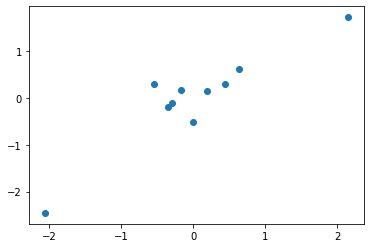

In [2]:
# Data generation
X, y = generate_dataset(10, 1, 10)
X_without_intercept = X[:,0]
X = X.tolist()
y = y.tolist()
plt.scatter(X_without_intercept, y)
plt.show()

In [3]:
X

[[2.146829041614424, 1.0],
 [0.18588603426253317, 1.0],
 [-2.0574090086134404, 1.0],
 [-0.2918878305536005, 1.0],
 [-0.17073221332863653, 1.0],
 [0.0032098777605151668, 1.0],
 [-0.5407349443131177, 1.0],
 [0.44327651908962423, 1.0],
 [0.6310639571023478, 1.0],
 [-0.3495014330206488, 1.0]]

In [4]:
context = FracContext()
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19


## Timings of basic HE operations

In [32]:
# testing numbers
a = 13
b = 42

In [33]:
enc_a = encode_utils.encrypt_num(a)
enc_b = encode_utils.encrypt_num(b)

In [34]:
## time for encoding

In [35]:
%%timeit
enc_a = encode_utils.encrypt_num(a)
enc_b = encode_utils.encrypt_num(b)


6.32 ms ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%%timeit
encode_utils.add(enc_a, enc_b)

8.81 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%timeit
encode_utils.subtract(enc_a, enc_b)

11.8 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%%timeit
encode_utils.multiply(enc_a, enc_b)

45.5 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
enc_a = EncArray(a, encode_utils)
enc_b = EncArray(b, encode_utils)

6.57 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
enc_a = EncArray(a, encode_utils)
enc_b = EncArray(b, encode_utils)

In [43]:
%%timeit
enc_a + enc_b

26.1 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
enc_a - enc_b

28.2 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%%timeit
enc_a * enc_b

66.6 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Timings of Linear Regression model 

In [46]:
X_enc = EncArray(X, encode_utils)
y_enc = EncArray(y, encode_utils)

In [47]:
%%timeit
model = SecureLinearRegression()
model.fit_unencrypted(X, y, n_iter=1)

KeyboardInterrupt: 

In [123]:
%%timeit
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=False)

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
23.5 s ± 505 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timings of different initialization parameters

In [50]:
X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)

In [7]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
model = SecureLinearRegression()
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


ValueError: encrypted is not valid for encryption parameters

In [53]:
%%timeit
context = FracContext(poly_modulus="1x^2048 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)
X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)

print(f'================= Secure LR ==================')
init_weights = None
model = SecureLinearRegression()
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^2048 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


KeyboardInterrupt: 

In [3]:
%%timeit
context = FracContext(poly_modulus="1x^8192 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model = SecureLinearRegression()
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^8192 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


NameError: name 'model' is not defined

In [ ]:
## Different number of prime numbers

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

In [21]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=80, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 3600 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


ValueError: encrypted is not valid for encryption parameters

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=140, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=True)

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=True)

## Noise consumption

In [5]:
poly_modulus_list = ["1x^1024 + 1", "1x^2048 + 1", "1x^8192 + 1"]

noise_budget = np.empty((10, 3))

for i, poly_modulus in enumerate(poly_modulus_list):

    context = FracContext(poly_modulus=poly_modulus, 
                          coef_modulus_n_primes=20, plain_modulus=1 << 32)
    encode_utils = FractionalEncoderUtils(context)
    decode_utils = FractionalDecryptorUtils(context)
    
    X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)
    
    model = SecureLinearRegression()
    init_weights = None
    for n_iter in range(10):
        model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=False)
        init_weights = model.weigths
        noise_budget[n_iter, i] = max(model.weigths.noise_budget(decode_utils))
        print(f'Noise budget for {n_iter} iteration: {noise_budget[n_iter, i]}')

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1071.0
Iteration: 0
Noise budget for 1 iteration: 979.0
Iteration: 0
Noise budget for 2 iteration: 886.0
Iteration: 0
Noise budget for 3 iteration: 792.0
Iteration: 0
Noise budget for 4 iteration: 698.0
Iteration: 0
Noise budget for 5 iteration: 605.0
Iteration: 0
Noise budget for 6 iteration: 511.0
Iteration: 0
Noise budget for 7 iteration: 417.0
Iteration: 0
Noise budget for 8 iteration: 324.0
Iteration: 0
Noise budget for 9 iteration: 230.0
/ Encryption parameters:
| poly_modulus: 1x^2048 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1066.0
Iteration: 0
Noise budget for 1 iteration: 968.0
Iteration: 0
Noise budget for 2 iteration: 870.0
Iteration: 0
Noise budget for 3 iteration: 771.0
Iteration: 0
Noise b

In [8]:
noise_budget[:,:-1]

array([[1071., 1066., 1058.],
       [ 979.,  968.,  952.],
       [ 886.,  870.,  846.],
       [ 792.,  771.,  740.],
       [ 698.,  672.,  634.],
       [ 605.,  574.,  528.],
       [ 511.,  475.,  422.],
       [ 417.,  377.,  316.],
       [ 324.,  278.,  210.],
       [ 230.,  180.,  104.]])

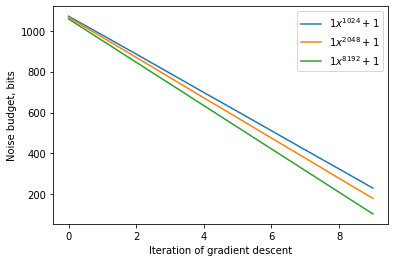

In [19]:
# ", "1x^2048 + 1", "1x^8192 + 1
plt.plot(noise_budget[:,0], label='$1x^{1024} + 1$')
plt.plot(noise_budget[:,1], label='$1x^{2048} + 1$')
plt.plot(noise_budget[:,2], label='$1x^{8192} + 1$')
plt.xlabel('Iteration of gradient descent')
plt.ylabel('Noise budget, bits')
plt.legend()
plt.savefig('noise_budget_1.png', dpi = 300)

In [21]:
coef_modulus_n_primes_list = [20, 40, 80, 140]

noise_budget_coef = np.empty((10, 4))

for i, coef_modulus_n_primes in enumerate(coef_modulus_n_primes_list):

    context = FracContext(poly_modulus="1x^1024 + 1", 
                          coef_modulus_n_primes=coef_modulus_n_primes, plain_modulus=1 << 32)
    encode_utils = FractionalEncoderUtils(context)
    decode_utils = FractionalDecryptorUtils(context)
    
    X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)
    
    model = SecureLinearRegression()
    init_weights = None
    for n_iter in range(10):
        model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=False)
        init_weights = model.weigths
        noise_budget_coef[n_iter, i] = max(model.weigths.noise_budget(decode_utils))
        print(f'Noise budget for {n_iter} iteration: {noise_budget_coef[n_iter, i]}')

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1068.0
Iteration: 0
Noise budget for 1 iteration: 971.0
Iteration: 0
Noise budget for 2 iteration: 874.0
Iteration: 0
Noise budget for 3 iteration: 777.0
Iteration: 0
Noise budget for 4 iteration: 680.0
Iteration: 0
Noise budget for 5 iteration: 583.0
Iteration: 0
Noise budget for 6 iteration: 486.0
Iteration: 0
Noise budget for 7 iteration: 388.0
Iteration: 0
Noise budget for 8 iteration: 291.0
Iteration: 0
Noise budget for 9 iteration: 194.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 2400 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 2268.0
Iteration: 0
Noise budget for 1 iteration: 2172.0
Iteration: 0
Noise budget for 2 iteration: 2075.0
Iteration: 0
Noise budget for 3 iteration: 1978.0
Iteration: 0
Nois

In [22]:
noise_budget_coef

array([[1068., 2268., 3467., 3470.],
       [ 971., 2172., 3371., 3376.],
       [ 874., 2075., 3274., 3283.],
       [ 777., 1978., 3178., 3189.],
       [ 680., 1880., 3081., 3094.],
       [ 583., 1783., 2985., 3000.],
       [ 486., 1686., 2888., 2906.],
       [ 388., 1589., 2792., 2812.],
       [ 291., 1492., 2695., 2718.],
       [ 194., 1395., 2599., 2624.]])

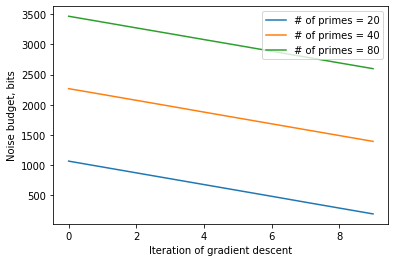

In [24]:
plt.plot(noise_budget_coef[:,0], label='# of primes = 20')
plt.plot(noise_budget_coef[:,1], label='# of primes = 40')
plt.plot(noise_budget_coef[:,2], label='# of primes = 80')

plt.xlabel('Iteration of gradient descent')
plt.ylabel('Noise budget, bits')
plt.legend()
plt.savefig('noise_budget_2.png', dpi = 300)

In [26]:
n_features_list = [1, 2, 3, 4, 5]

noise_budget_features = np.empty((10, 5))

for i, n_features in enumerate(n_features_list):
    
    X, y = generate_dataset(10, n_features, 10)
    X = X.tolist()
    y = y.tolist()

    context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
    encode_utils = FractionalEncoderUtils(context)
    decode_utils = FractionalDecryptorUtils(context)
    
    X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)
    
    model = SecureLinearRegression()
    init_weights = None
    for n_iter in range(2):
        model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=False)
        init_weights = model.weigths
        noise_budget_features[n_iter, i] = max(model.weigths.noise_budget(decode_utils))
        print(f'Noise budget for {n_iter} iteration: {noise_budget_features[n_iter, i]}')

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1068.0
Iteration: 0
Noise budget for 1 iteration: 971.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1070.0
Iteration: 0
Noise budget for 1 iteration: 973.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1068.0
Iteration: 0
Noise budget for 1 iteration: 972.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1067.0
Iteration: 0
Noise budget for 1 iteration: 968.0
/ Encryption paramet

In [27]:
data_sizes_list = [5, 10, 20, 30]

noise_budget_sizes = np.empty((10, 4))

for i, size in enumerate(data_sizes_list):
    
    X, y = generate_dataset(size, 1, 10)
    X = X.tolist()
    y = y.tolist()

    context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
    encode_utils = FractionalEncoderUtils(context)
    decode_utils = FractionalDecryptorUtils(context)
    
    X_enc, y_enc = EncArray(X, enc_utils=encode_utils), EncArray(y, enc_utils=encode_utils)
    
    model = SecureLinearRegression()
    init_weights = None
    for n_iter in range(2):
        model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=False)
        init_weights = model.weigths
        noise_budget_sizes[n_iter, i] = max(model.weigths.noise_budget(decode_utils))
        print(f'Noise budget for {n_iter} iteration: {noise_budget_sizes[n_iter, i]}')

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1070.0
Iteration: 0
Noise budget for 1 iteration: 977.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1071.0
Iteration: 0
Noise budget for 1 iteration: 979.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1067.0
Iteration: 0
Noise budget for 1 iteration: 969.0
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
Iteration: 0
Noise budget for 0 iteration: 1064.0
Iteration: 0
Noise budget for 1 iteration: 964.0
